In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder


Смотрю сначала трейн-выборку и данные о ней.

In [2]:
data_train =pd.read_csv('/content/train.csv')
data_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Есть пустые значения. Смотрю общие данные и корреляцию. После заполню их.
***
Перевожу данные стоимости билета в целочисленный тип данных. Данные после запятой не информативны.

In [4]:
data_train['Fare']= data_train['Fare'].astype(int)

In [5]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,31.785634
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.703730
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.000000


In [6]:
data_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012668
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257482
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.550553
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096284
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159506
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216252
Fare,0.012668,0.257482,-0.550553,0.096284,0.159506,0.216252,1.000000


Интересна макс.стоимость в 512 при среднем 32. Проверяю не вброс ли это.

<Axes: >

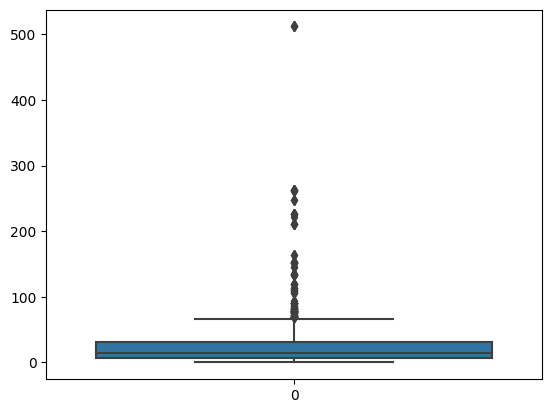

In [7]:
sns.boxplot(data_train['Fare'])

Вброс подтвердился. Удаляю.

In [8]:
data_train = data_train[data_train['Fare']<300.00]

Остальные данные с большим разбросом похожи на рельаность. Например, возраст может 80 лет так и новорожденный.
***
Корреляция данных слабая.
***
Заполняю данные возраста средним значением.

In [9]:
data_train['Age']= data_train['Age'].fillna(data_train['Age'].median())
data_train['Age']= data_train['Age'].astype(int)

data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  888 non-null    int64 
 1   Survived     888 non-null    int64 
 2   Pclass       888 non-null    int64 
 3   Name         888 non-null    object
 4   Sex          888 non-null    object
 5   Age          888 non-null    int64 
 6   SibSp        888 non-null    int64 
 7   Parch        888 non-null    int64 
 8   Ticket       888 non-null    object
 9   Fare         888 non-null    int64 
 10  Cabin        202 non-null    object
 11  Embarked     886 non-null    object
dtypes: int64(7), object(5)
memory usage: 90.2+ KB


In [10]:
data_train[data_train['Embarked'].isnull()].index.tolist()

[61, 829]

In [11]:
data_train = data_train.drop (index=[ 61, 829])

In [12]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  886 non-null    int64 
 1   Survived     886 non-null    int64 
 2   Pclass       886 non-null    int64 
 3   Name         886 non-null    object
 4   Sex          886 non-null    object
 5   Age          886 non-null    int64 
 6   SibSp        886 non-null    int64 
 7   Parch        886 non-null    int64 
 8   Ticket       886 non-null    object
 9   Fare         886 non-null    int64 
 10  Cabin        200 non-null    object
 11  Embarked     886 non-null    object
dtypes: int64(7), object(5)
memory usage: 90.0+ KB


Осталось два пустых значения по отправлению - "Embarked". Удаляю их.

Познакомлюсь с пассажирами перед обучением моделей

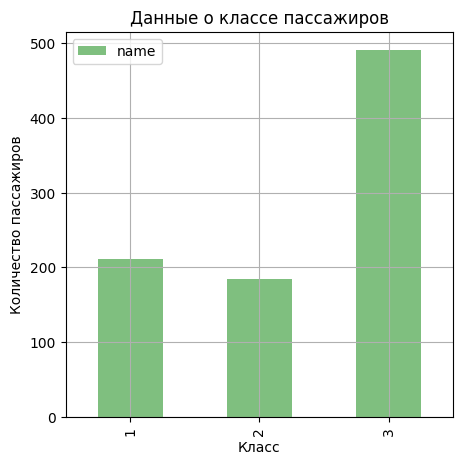

In [13]:
class_pd= data_train.groupby('Pclass').agg(name = ('Name', 'count'))
class_pd.plot(grid=True, kind = 'bar', color = 'green', alpha = 0.5, figsize=(5, 5))
plt.title('Данные о классе пассажиров')
plt.xlabel('Класс')
plt.ylabel('Количество пассажиров')
plt.show()

,name,%
Survived,,
0,549,0.618243
1,337,0.379505


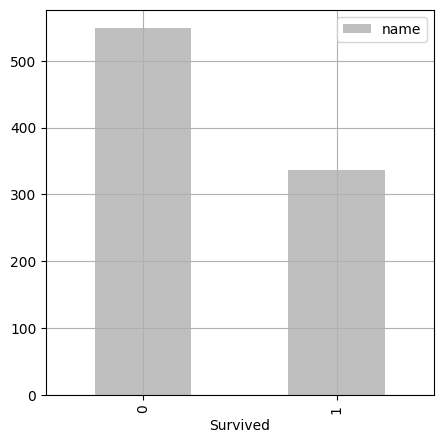

In [14]:
Survived_pd= data_train.groupby('Survived').agg(name = ('Name', 'count'))
Survived_pd.plot(grid=True, kind = 'bar', color = 'gray', alpha = 0.5, figsize=(5, 5))

Survived_pd['%'] = Survived_pd['name']/888
Survived_pd

* Большая часть пассажиров приобрела бюджетный 3 класс.
* Выжило всего 38%

***
Приступаю к обучению модели. Но сначала удалю ненужные данные для обучения: имя и фамилия пассажиров. Пол переведу в числовые данные из категориальных.

In [15]:
data_train = data_train.drop(['Name', 'Cabin', 'Ticket'], axis=1)

data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  886 non-null    int64 
 1   Survived     886 non-null    int64 
 2   Pclass       886 non-null    int64 
 3   Sex          886 non-null    object
 4   Age          886 non-null    int64 
 5   SibSp        886 non-null    int64 
 6   Parch        886 non-null    int64 
 7   Fare         886 non-null    int64 
 8   Embarked     886 non-null    object
dtypes: int64(7), object(2)
memory usage: 69.2+ KB


In [16]:
features = data_train.drop(['Survived'], axis=1)
target = data_train['Survived']

features

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,male,22,1,0,7,S
1,2,1,female,38,1,0,71,C
2,3,3,female,26,0,0,7,S
3,4,1,female,35,1,0,53,S
4,5,3,male,35,0,0,8,S
...,...,...,...,...,...,...,...,...
886,887,2,male,27,0,0,13,S
887,888,1,female,19,0,0,30,S
888,889,3,female,28,1,2,23,S
889,890,1,male,26,0,0,30,C


In [17]:
encoder = OrdinalEncoder()
encoder.fit(features)
features_ordinal =  pd.DataFrame(encoder.fit_transform(features),columns=features.columns)

features_ordinal

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,2.0,1.0,22.0,1.0,0.0,4.0,2.0
1,1.0,0.0,0.0,38.0,1.0,0.0,56.0,0.0
2,2.0,2.0,0.0,26.0,0.0,0.0,4.0,2.0
3,3.0,0.0,0.0,35.0,1.0,0.0,46.0,2.0
4,4.0,2.0,1.0,35.0,0.0,0.0,5.0,2.0
...,...,...,...,...,...,...,...,...
881,881.0,1.0,1.0,27.0,0.0,0.0,10.0,2.0
882,882.0,0.0,0.0,19.0,0.0,0.0,27.0,2.0
883,883.0,2.0,0.0,28.0,1.0,2.0,20.0,2.0
884,884.0,0.0,1.0,26.0,0.0,0.0,27.0,0.0


In [18]:
best_model = None
best_result = 0
best_depth = 0
for est in tqdm(range(1, 50, 2)):
    for depth in (range(1, 20, 2)):
        RF = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth, criterion='gini')
        RF.fit(features_ordinal, target)
        result = RF.score(features_ordinal, target)
        if result > best_result:
            best_model = RF
            best_result = result
            best_est = est
            best_depth = depth

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Est при лучшем результате:", best_est)
print("Depth при лучшем результате:", best_depth)

100%|██████████| 25/25 [00:33<00:00,  1.33s/it]

Accuracy наилучшей модели на валидационной выборке: 1.0
Est при лучшем результате: 45
Depth при лучшем результате: 19


In [19]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 50, 2):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_ordinal, target)
    predictions = model.predict(features_ordinal)
    result = accuracy_score(target, predictions)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

print("Accuracy лучшей модели:", best_result)
print("Depth при лучшем результате:", best_depth)

Accuracy лучшей модели: 1.0
Depth при лучшем результате: 19


Обе модели показали `accuracy_score` -  **1**.
Для тестирования возьму RandomForestClassifier.
***
Загружаю тестовые значния, готовлю их к проверке.

In [20]:
data_test =pd.read_csv('/content/test.csv')
data_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [21]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [22]:
data_test['Age']= data_test['Age'].fillna(data_test['Age'].median())
data_test['Fare']= data_test['Fare'].fillna(data_test['Fare'].median())

data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [23]:
test = data_test.drop(['Name', 'Cabin', 'Ticket'], axis=1)

In [24]:
test_encoder = OrdinalEncoder()
test_encoder.fit(test)
test_ordinal =  pd.DataFrame(test_encoder.fit_transform(test),columns=test.columns)

test_ordinal

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,2.0,1.0,44.0,0.0,0.0,24.0,1.0
1,1.0,2.0,0.0,60.0,1.0,0.0,5.0,2.0
2,2.0,1.0,1.0,74.0,0.0,0.0,41.0,1.0
3,3.0,2.0,1.0,34.0,0.0,0.0,34.0,2.0
4,4.0,2.0,0.0,27.0,1.0,1.0,46.0,2.0
...,...,...,...,...,...,...,...,...
413,413.0,2.0,1.0,34.0,0.0,0.0,31.0,2.0
414,414.0,0.0,0.0,51.0,0.0,0.0,154.0,0.0
415,415.0,2.0,1.0,50.0,0.0,0.0,9.0,2.0
416,416.0,2.0,1.0,34.0,0.0,0.0,31.0,2.0


Применяю к тестовым данным модель и добавляю в тест предсказания.

In [25]:
model_test = DecisionTreeClassifier(random_state = 12345, max_depth=7)
model_test.fit(features_ordinal, target)
pred_test = model_test.predict(test_ordinal)


Сохраняю предсказания и id пассажира

In [26]:
DATA_SURVIVED=data_test[['PassengerId']]
DATA_SURVIVED['Survived']=pred_test
DATA_SURVIVED.to_csv('DATA_SURVIVED.csv', index=False)

DATA_SURVIVED

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Теперь надо выяснить кто из тестовой выборки спасся.

,name,%
Survived,,
0,283,0.677033
1,135,0.322967


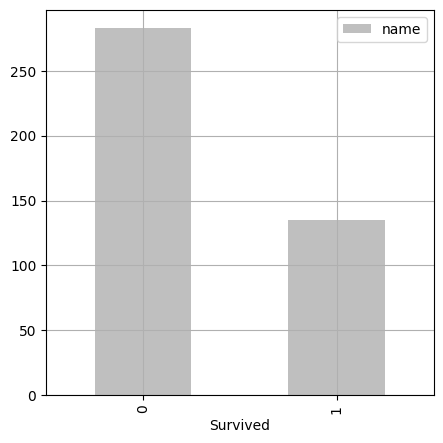

In [27]:
data_test['Survived']=DATA_SURVIVED['Survived']

pd_survived= data_test.groupby('Survived').agg(name = ('Name', 'count'))
pd_survived.plot(grid=True, kind = 'bar', color = 'gray', alpha = 0.5, figsize=(5, 5))

pd_survived['%'] = pd_survived['name']/418
pd_survived

Спаслось более 32%.
***
Выясню кто эти спасенные

In [28]:
survived=data_test.query('Survived==1')
survived

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
12,904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,23.0,1,0,21228,82.2667,B45,S,1
14,906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,47.0,1,0,W.E.P. 5734,61.1750,E31,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
397,1289,1,"Frolicher-Stehli, Mrs. Maxmillian (Margaretha ...",female,48.0,1,1,13567,79.2000,B41,C,1
400,1292,1,"Bonnell, Miss. Caroline",female,30.0,0,0,36928,164.8667,C7,S,1
402,1294,1,"Gibson, Miss. Dorothy Winifred",female,22.0,0,1,112378,59.4000,NaN,C,1
411,1303,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q,1


,name
Sex,
female,112
male,23


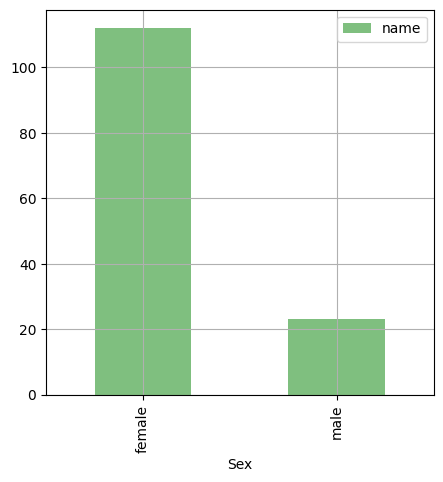

In [29]:
survived_gender= survived.groupby('Sex').agg(name = ('Name', 'count'))
survived_gender.plot(grid=True, kind = 'bar', color = 'green', alpha = 0.5, figsize=(5, 5))
survived_gender

,name,%
Pclass,,
1,51,0.472222
2,47,0.435185
3,37,0.342593


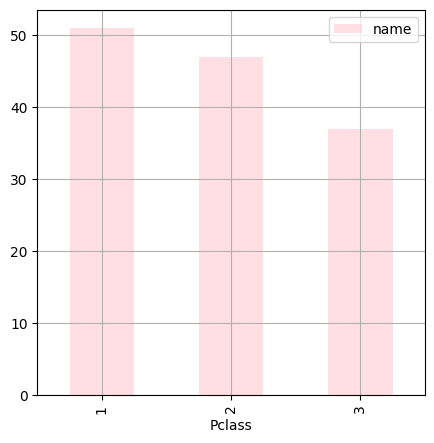

In [30]:
survived_class= survived.groupby('Pclass').agg(name = ('Name', 'count'))
survived_class.plot(grid=True, kind = 'bar', color = 'pink', alpha = 0.5, figsize=(5, 5))

survived_class['%'] = survived_class['name']/108
survived_class

In [31]:
survived.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.0
mean,1080.459259,1.896296,30.995037,0.407407,0.488889,53.532563,1.0
std,124.223785,0.803668,15.410307,0.589666,0.799876,76.484620,0.0
min,893.000000,1.000000,0.330000,0.000000,0.000000,3.170800,1.0
25%,969.500000,1.000000,22.000000,0.000000,0.000000,12.937500,1.0
50%,1072.000000,2.000000,27.000000,0.000000,0.000000,23.450000,1.0
75%,1192.000000,3.000000,40.500000,1.000000,1.000000,59.400000,1.0
max,1306.000000,3.000000,76.000000,3.000000,4.000000,512.329200,1.0


## Вывод
* Исходя из прогнозов спаслось бОльшее количество женщин.
* 47% спасенных были из пассажиров 1 класса.
* Средний возраст спасенных - 31 год.